In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch import autograd
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

from torchsummary import summary
from torchvision.utils import save_image
import os
import time

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
!pwd
!ls

/home/ubuntu/plant_diseases
README.md		     WGAN_gp_tomato_img_size-224_feature-100.ipynb
WGAN_gp_tomato_224_v2.ipynb  data


In [27]:
dataroot = "./data/Tomato/"
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 20

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 224

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 64

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [8]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [9]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

https://github.com/pytorch/examples/issues/70

In [10]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 7, 1, 0, bias=False), #nz チャンネル * 1*1 テンソルを ngf*16 * (2*2)のテンソルに変更
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True), #in-place option = True?メモリの節約？
            # state size. (ngf*8) x 7 x 7
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf*8) x 14 x 14
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 28 x 28
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 4, 0, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            # state size. (ngf*2) x 112 x 112
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 224 x 224
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)
#summary(netG, input_size=(128, 128, 3))

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(4, 4), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 224 x 224
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 112 x 112
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 56 x 56
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 28 x 28
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 14 x 14
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 7 x 7
            nn.Conv2d(ndf * 16, 1, 7, 1, 0, bias=False), #チャンネル数1, 1*1のテンソル
            #nn.Sigmoid() #sigmoidで[0, 1]の範囲に収め, 確率にする
            # state size. 1
        )

    def forward(self, input):
        return self.main(input) #feedforward


# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [12]:
def compute_gradient_penalty(real_images, fake_images):
    B_size = real_images.size(0)
    eta = torch.FloatTensor(B_size,1,1,1).uniform_(0,1).to(device) #(batch_size, 1, 1, 1)の形の乱数によるtensorを作る
    eta = eta.expand(B_size, real_images.size(1), real_images.size(2), real_images.size(3)) #expandにより (batch_size, 1, 1, 1) -> (batch_size, real_images.size(1), real_images.size(2), real_images.size(3))に複製・拡大する
    interpolated = eta * real_images + ((1 - eta) * fake_images) #etaによるreal imageとfake imageの内分点をとる
    interpolated = torch.tensor(interpolated, requires_grad=True) #requires_grad特性をTrueにする
    prob_interpolated = netD(interpolated) #descriminator(critic)によるinterpolatedのoutputを計算
    gradients = autograd.grad(outputs=prob_interpolated, #outputはprob_interpolated, inputはinterpolatedとして微分を計算する
                            inputs=interpolated,
                            grad_outputs=torch.ones(prob_interpolated.size()).to(device),
                            create_graph=True,
                            retain_graph=True)[0] #これはinputのテンソルを1つ固定して, それで微分した後にoutputに関して和を取るのと一緒
    grad_penalty = ((gradients.norm(2, dim=(1,2,3)) - 1) ** 2).mean() #dim=(1,2,3)に関して添字が走るベクトルだと思ってL2normを計算.この場合,batch_size分のnormが得られるのでそれに関して(-1と２乗をした後に)平均をとる
    return grad_penalty

In [13]:
# Number of training epochs
num_epochs = 500

# Number of generator iterations
g_iters = 2

# Parameter for the gradient penalty
lambda_gp = 10 
# Initialize BCELoss function
#criterion = nn.BCELoss() #binary cross entropy(-ylogx - (1-y)log(1-x)) の最小化でオッケー

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) #latent space vector

# Establish convention for real and fake labels during training 
real_label = 1. #realなら1 
fake_label = 0. #fakeなら0

# Setup Adam optimizers for both G and D
lrD = 0.0002
lrG = 0.00022
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999)) #netDのパラメータだけ更新
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999)) #netGのパラメータだけ更新

In [28]:
import datetime
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(dataloader, 0): #enumerate(dataloader, 0)とは0から始めるindexを付与しながら取ってくる
    ############################
    # (1) Update D network: minimize -E(D(x)) + E(D(G(z))) + lambda_gp*E(|grad(D(y)) - 1|^2)
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real_cpu = data[0].to(device) #data[0] はmini batch内の画像のテンソル全て
    b_size = real_cpu.size(0) #minibatchのサイズ
    # Forward pass real batch through D
    Dreal = netD(real_cpu).view(-1) #1列に直すために.view(-1)
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device) #(b_size, nz, 1, 1)の乱数を作る
    # Generate fake image batch with G
    fake = netG(noise) 
    # Calculate the critic for all fake batch
    Dfake = netD(fake.detach()).view(-1) #detachをすることで, 計算グラフから切り離されたコピーを作る
    # Calculate loss on all batch
    errD = -Dreal.mean() + Dfake.mean() + lambda_gp * compute_gradient_penalty(real_images=real_cpu, fake_images=fake) #gradient penaltyを追加したloss function
    errD.backward() #バックワード (errD_realのgradientを計算)
    D_x = Dreal.mean().item() #D(real data)の平均
    D_G_z1 = Dfake.mean().item() #D(G(z))の平均(0の方がDは仕事をしている)
    # Update D
    optimizerD.step()
    netG.zero_grad() #以降のために, 一応ここでGのgradientを0に初期化しておく
    ############################
    # (2) Update G network: minimize -E(C(G(z)))
    ###########################
    for j in range(g_iters):
        netG.zero_grad()
        fake = netG(noise) #改めてfake画像を生成(その必要は本当にあるのか?)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1) #D(G(z))
        # Calculate G's loss based on this output
        errG = -output.mean() #Gに対するloss function
        # Calculate gradients for G
        errG.backward() #微分
        D_G_z2 = output.mean().item() #平均
        # Update G
        optimizerG.step() #パラメータの更新



    # Output training stats
    if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(dataloader),
                  errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        print('{}'.format(datetime.datetime.now()))
    
    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    
    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
    iters += 1

Starting Training Loop...


/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


[0/500][0/4]	Loss_D: -27.0299	Loss_G: -20.9863	D(x): 54.4571	D(G(z)): 21.7034 / 20.9863
2021-03-01 11:43:13.297678
[1/500][0/4]	Loss_D: -32.7107	Loss_G: -12.5906	D(x): 52.5303	D(G(z)): 14.6052 / 12.5906
2021-03-01 11:43:16.185189
[2/500][0/4]	Loss_D: -29.6124	Loss_G: -10.6300	D(x): 44.5902	D(G(z)): 9.8069 / 10.6300
2021-03-01 11:43:18.649536
[3/500][0/4]	Loss_D: -30.2036	Loss_G: -9.6493	D(x): 44.7101	D(G(z)): 9.0292 / 9.6493
2021-03-01 11:43:21.332843
[4/500][0/4]	Loss_D: -31.1665	Loss_G: -4.4761	D(x): 43.8726	D(G(z)): 6.8204 / 4.4761
2021-03-01 11:43:24.014239
[5/500][0/4]	Loss_D: -34.8527	Loss_G: -5.5094	D(x): 44.5521	D(G(z)): 4.2413 / 5.5094
2021-03-01 11:43:26.687327
[6/500][0/4]	Loss_D: -32.6011	Loss_G: -11.2589	D(x): 48.8471	D(G(z)): 12.5464 / 11.2589
2021-03-01 11:43:29.374128
[7/500][0/4]	Loss_D: -31.7304	Loss_G: -17.2834	D(x): 54.1349	D(G(z)): 17.7541 / 17.2834
2021-03-01 11:43:32.054817
[8/500][0/4]	Loss_D: -33.4615	Loss_G: -16.0094	D(x): 54.6512	D(G(z)): 15.8824 / 16.0094
20

[72/500][0/4]	Loss_D: -41.5458	Loss_G: -17.2259	D(x): 67.1327	D(G(z)): 16.3771 / 17.2259
2021-03-01 11:46:25.311717
[73/500][0/4]	Loss_D: -39.9039	Loss_G: -20.5122	D(x): 71.4349	D(G(z)): 22.5704 / 20.5122
2021-03-01 11:46:27.973897
[74/500][0/4]	Loss_D: -48.5282	Loss_G: -16.3079	D(x): 73.5256	D(G(z)): 15.0475 / 16.3079
2021-03-01 11:46:30.646576
[75/500][0/4]	Loss_D: -45.2633	Loss_G: -11.0933	D(x): 65.5155	D(G(z)): 11.1259 / 11.0933
2021-03-01 11:46:33.348692
[76/500][0/4]	Loss_D: -43.5592	Loss_G: -15.9637	D(x): 64.6488	D(G(z)): 8.5274 / 15.9637
2021-03-01 11:46:36.058907
[77/500][0/4]	Loss_D: -44.7753	Loss_G: -8.4072	D(x): 67.1649	D(G(z)): 8.0433 / 8.4072
2021-03-01 11:46:38.751734
[78/500][0/4]	Loss_D: -48.8967	Loss_G: -8.1502	D(x): 67.5299	D(G(z)): 10.7740 / 8.1502
2021-03-01 11:46:41.464636
[79/500][0/4]	Loss_D: -43.7688	Loss_G: -14.1454	D(x): 67.5334	D(G(z)): 12.1407 / 14.1454
2021-03-01 11:46:44.150317
[80/500][0/4]	Loss_D: -50.6426	Loss_G: -10.0502	D(x): 71.3831	D(G(z)): 12.1955

[143/500][0/4]	Loss_D: -59.1556	Loss_G: -8.2314	D(x): 83.6409	D(G(z)): 6.4939 / 8.2314
2021-03-01 11:49:34.920778
[144/500][0/4]	Loss_D: -59.0173	Loss_G: -12.3999	D(x): 84.6893	D(G(z)): 10.9587 / 12.3999
2021-03-01 11:49:37.625463
[145/500][0/4]	Loss_D: -51.0885	Loss_G: -15.0028	D(x): 82.2064	D(G(z)): 11.8073 / 15.0028
2021-03-01 11:49:40.336817
[146/500][0/4]	Loss_D: -54.0396	Loss_G: -9.5482	D(x): 76.6524	D(G(z)): 8.6465 / 9.5482
2021-03-01 11:49:43.039420
[147/500][0/4]	Loss_D: -52.3477	Loss_G: -10.3445	D(x): 82.7442	D(G(z)): 7.4917 / 10.3445
2021-03-01 11:49:45.717766
[148/500][0/4]	Loss_D: -56.7425	Loss_G: -14.2758	D(x): 80.2849	D(G(z)): 15.0768 / 14.2758
2021-03-01 11:49:48.401068
[149/500][0/4]	Loss_D: -52.1516	Loss_G: -11.1809	D(x): 83.9793	D(G(z)): 11.0585 / 11.1809
2021-03-01 11:49:51.033728
[150/500][0/4]	Loss_D: -54.3639	Loss_G: -3.5659	D(x): 76.1790	D(G(z)): 6.7566 / 3.5659
2021-03-01 11:49:53.729317
[151/500][0/4]	Loss_D: -52.2236	Loss_G: -10.0977	D(x): 80.2634	D(G(z)): 11

[214/500][0/4]	Loss_D: -60.5011	Loss_G: -22.2729	D(x): 104.8373	D(G(z)): 20.6095 / 22.2729
2021-03-01 11:52:44.456912
[215/500][0/4]	Loss_D: -64.5307	Loss_G: -10.5995	D(x): 94.3196	D(G(z)): 9.6543 / 10.5995
2021-03-01 11:52:47.151928
[216/500][0/4]	Loss_D: -67.9507	Loss_G: -15.9360	D(x): 105.1573	D(G(z)): 15.7391 / 15.9360
2021-03-01 11:52:49.838867
[217/500][0/4]	Loss_D: -61.8383	Loss_G: -18.5641	D(x): 108.6027	D(G(z)): 15.9080 / 18.5641
2021-03-01 11:52:52.533307
[218/500][0/4]	Loss_D: -66.0113	Loss_G: -10.7029	D(x): 94.9689	D(G(z)): 12.2070 / 10.7029
2021-03-01 11:52:54.940946
[219/500][0/4]	Loss_D: -71.2103	Loss_G: -10.8386	D(x): 104.4088	D(G(z)): 12.4434 / 10.8386
2021-03-01 11:52:57.639624
[220/500][0/4]	Loss_D: -66.0644	Loss_G: -8.9253	D(x): 92.5584	D(G(z)): 9.0011 / 8.9253
2021-03-01 11:53:00.321214
[221/500][0/4]	Loss_D: -70.1099	Loss_G: -10.4370	D(x): 103.1931	D(G(z)): 11.4738 / 10.4370
2021-03-01 11:53:02.992055
[222/500][0/4]	Loss_D: -67.5707	Loss_G: -11.1228	D(x): 95.4634	

[284/500][0/4]	Loss_D: -58.6259	Loss_G: -20.2779	D(x): 90.4106	D(G(z)): 24.1229 / 20.2779
2021-03-01 11:55:51.480674
[285/500][0/4]	Loss_D: -80.8052	Loss_G: -11.9751	D(x): 110.8131	D(G(z)): 12.7303 / 11.9751
2021-03-01 11:55:54.160022
[286/500][0/4]	Loss_D: -73.1516	Loss_G: -9.3419	D(x): 112.5999	D(G(z)): 5.1324 / 9.3419
2021-03-01 11:55:56.613545
[287/500][0/4]	Loss_D: -72.7524	Loss_G: -5.7584	D(x): 106.3005	D(G(z)): 4.7591 / 5.7584
2021-03-01 11:55:59.309930
[288/500][0/4]	Loss_D: -72.3133	Loss_G: -13.5893	D(x): 114.2310	D(G(z)): 13.3706 / 13.5893
2021-03-01 11:56:02.011966
[289/500][0/4]	Loss_D: -65.8285	Loss_G: -20.0350	D(x): 115.4325	D(G(z)): 16.4014 / 20.0350
2021-03-01 11:56:04.713902
[290/500][0/4]	Loss_D: -73.0729	Loss_G: -11.0276	D(x): 105.1731	D(G(z)): 10.3115 / 11.0276
2021-03-01 11:56:07.430326
[291/500][0/4]	Loss_D: -80.5793	Loss_G: -11.4095	D(x): 119.9066	D(G(z)): 10.4932 / 11.4095
2021-03-01 11:56:10.142144
[292/500][0/4]	Loss_D: -63.5925	Loss_G: -17.3061	D(x): 97.8042	

[354/500][0/4]	Loss_D: -86.4524	Loss_G: -18.6579	D(x): 139.8520	D(G(z)): 14.5236 / 18.6579
2021-03-01 11:58:57.942569
[355/500][0/4]	Loss_D: -82.2174	Loss_G: -11.6275	D(x): 124.7853	D(G(z)): 14.9098 / 11.6275
2021-03-01 11:59:00.638660
[356/500][0/4]	Loss_D: -84.2365	Loss_G: -19.4331	D(x): 123.5114	D(G(z)): 15.3615 / 19.4331
2021-03-01 11:59:03.329283
[357/500][0/4]	Loss_D: -78.5189	Loss_G: -19.6010	D(x): 129.6175	D(G(z)): 17.2414 / 19.6010
2021-03-01 11:59:06.038224
[358/500][0/4]	Loss_D: -84.0794	Loss_G: -15.8055	D(x): 136.6920	D(G(z)): 15.6315 / 15.8055
2021-03-01 11:59:08.737871
[359/500][0/4]	Loss_D: -84.8005	Loss_G: -21.6546	D(x): 128.4888	D(G(z)): 23.8176 / 21.6546
2021-03-01 11:59:11.419017
[360/500][0/4]	Loss_D: -64.7411	Loss_G: -7.6288	D(x): 140.4648	D(G(z)): 8.7728 / 7.6288
2021-03-01 11:59:14.109330
[361/500][0/4]	Loss_D: -74.5100	Loss_G: -9.8956	D(x): 117.0300	D(G(z)): 3.7630 / 9.8956
2021-03-01 11:59:16.780385
[362/500][0/4]	Loss_D: -82.9692	Loss_G: -19.0478	D(x): 122.909

[424/500][0/4]	Loss_D: -99.4060	Loss_G: -12.1713	D(x): 142.4602	D(G(z)): 7.5461 / 12.1713
2021-03-01 12:02:05.148127
[425/500][0/4]	Loss_D: -89.7951	Loss_G: -12.3902	D(x): 143.5515	D(G(z)): 14.8689 / 12.3902
2021-03-01 12:02:07.820457
[426/500][0/4]	Loss_D: -87.6414	Loss_G: -18.5686	D(x): 156.0348	D(G(z)): 18.9728 / 18.5686
2021-03-01 12:02:10.502236
[427/500][0/4]	Loss_D: -58.3701	Loss_G: -18.7110	D(x): 163.2904	D(G(z)): 18.7107 / 18.7110
2021-03-01 12:02:13.213024
[428/500][0/4]	Loss_D: -94.3196	Loss_G: -6.3612	D(x): 138.1723	D(G(z)): 13.2737 / 6.3612
2021-03-01 12:02:15.903055
[429/500][0/4]	Loss_D: -61.3457	Loss_G: -6.8489	D(x): 135.8391	D(G(z)): 7.4299 / 6.8489
2021-03-01 12:02:18.607289
[430/500][0/4]	Loss_D: -64.0872	Loss_G: -20.1623	D(x): 153.6486	D(G(z)): 17.0313 / 20.1623
2021-03-01 12:02:21.297712
[431/500][0/4]	Loss_D: -77.2720	Loss_G: -25.2806	D(x): 157.8768	D(G(z)): 24.9756 / 25.2806
2021-03-01 12:02:23.987588
[432/500][0/4]	Loss_D: -109.4872	Loss_G: -17.4114	D(x): 157.36

[494/500][0/4]	Loss_D: -109.2337	Loss_G: 3.7629	D(x): 139.7580	D(G(z)): -5.7684 / -3.7629
2021-03-01 12:05:12.321765
[495/500][0/4]	Loss_D: -80.3020	Loss_G: -25.0596	D(x): 119.5612	D(G(z)): 22.9250 / 25.0596
2021-03-01 12:05:15.014390
[496/500][0/4]	Loss_D: -92.3919	Loss_G: -4.5535	D(x): 180.8746	D(G(z)): 9.7618 / 4.5535
2021-03-01 12:05:17.699420
[497/500][0/4]	Loss_D: -86.7112	Loss_G: -26.1439	D(x): 131.8319	D(G(z)): 23.5439 / 26.1439
2021-03-01 12:05:20.372428
[498/500][0/4]	Loss_D: -79.9595	Loss_G: -26.8471	D(x): 173.1920	D(G(z)): 28.3801 / 26.8471
2021-03-01 12:05:23.049272
[499/500][0/4]	Loss_D: -96.2374	Loss_G: -18.3800	D(x): 149.3719	D(G(z)): 14.8364 / 18.3800
2021-03-01 12:05:25.747044


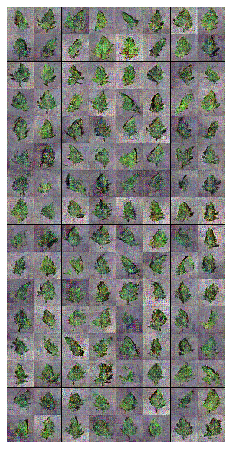

In [29]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

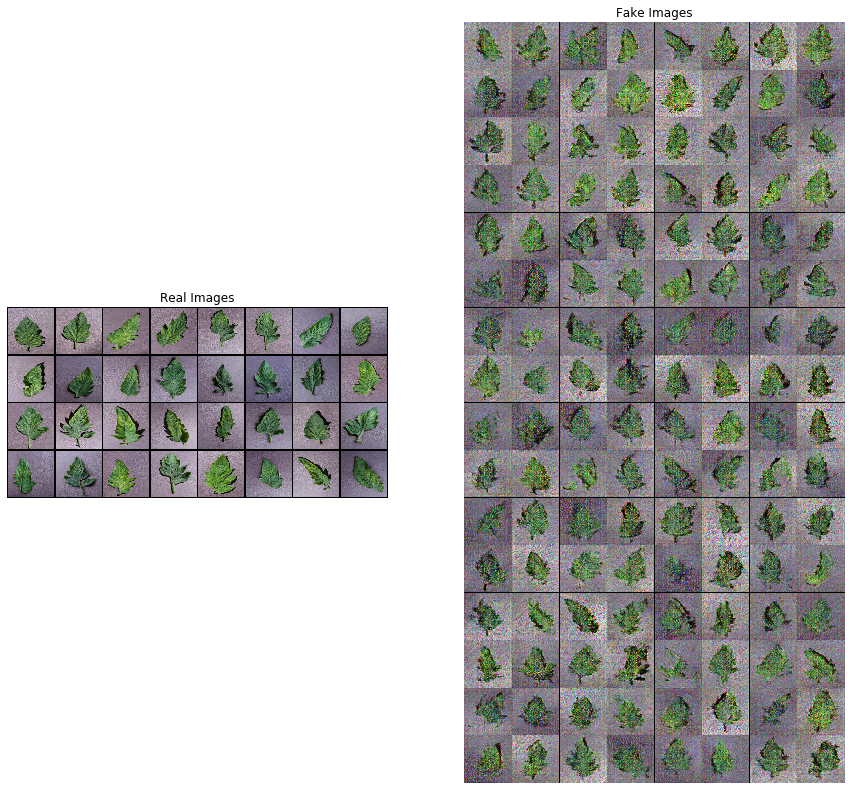

In [30]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

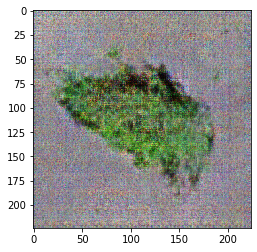

In [31]:
plt.imshow(np.transpose(0.5*(fake[0]+1)))

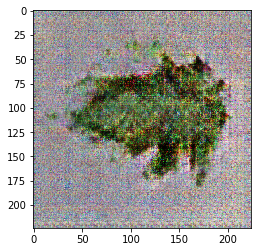

In [32]:
plt.imshow(np.transpose(0.5*(fake[63]+1)))

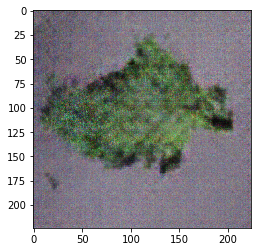

In [19]:
#
img0 = np.transpose(0.5*(fake[0]+1))
img1 = img0.numpy()
plt.imshow(img0)

tensor([[[-0.0902, -0.1529, -0.1137,  ..., -0.0745,  0.0431, -0.0745],
         [-0.0902, -0.1216, -0.0980,  ...,  0.0196, -0.0118, -0.0431],
         [-0.0667, -0.0667, -0.0824,  ..., -0.0353, -0.0039, -0.1294],
         ...,
         [ 0.2392,  0.2863,  0.3020,  ...,  0.4510,  0.4588,  0.4196],
         [ 0.2314,  0.2706,  0.2706,  ...,  0.4275,  0.4275,  0.4275],
         [ 0.2706,  0.2549,  0.2157,  ...,  0.4510,  0.4431,  0.4824]],

        [[-0.2000, -0.2627, -0.2235,  ..., -0.2078, -0.0902, -0.2078],
         [-0.2000, -0.2314, -0.2078,  ..., -0.1137, -0.1451, -0.1765],
         [-0.1765, -0.1765, -0.1922,  ..., -0.1686, -0.1373, -0.2627],
         ...,
         [ 0.1294,  0.1765,  0.1922,  ...,  0.3412,  0.3490,  0.3098],
         [ 0.1216,  0.1608,  0.1608,  ...,  0.3176,  0.3176,  0.3176],
         [ 0.1608,  0.1451,  0.1059,  ...,  0.3412,  0.3333,  0.3725]],

        [[-0.0824, -0.1451, -0.1059,  ..., -0.0824,  0.0353, -0.0824],
         [-0.0824, -0.1137, -0.0902,  ...,  0

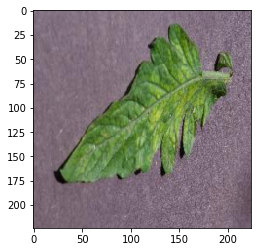

In [20]:
print((real_batch[0][1]), len(real_batch[0]))
plt.imshow(np.transpose(0.5*(real_batch[0][batch_size-1]+1)))

In [33]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
latent_b_size = 128  # batch size of latent vectors
fixed_noise = torch.randn(latent_b_size, nz, 1, 1, device=device) #latent space vector

with torch.no_grad():
    fake_img = netG(fixed_noise).detach().cpu()   # len(fake_img) = 64
#img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

for i in range(latent_b_size):
    imgfake = np.transpose(0.5*(fake_img[i]+1)).numpy()
    im = Image.fromarray((imgfake * 255).astype(np.uint8))
    im.save("./data64_1000_1/%03d.jpg" % i)

In [22]:
!pwd

/home/ubuntu/plant_diseases


In [ ]:
print((real_batch[0][1]), len(real_batch[0]))
plt.imshow(np.transpose(0.5*(real_batch[0][63]+1)))

In [17]:
def save_img_results(data_img, fake, epoch, image_dir):
    num = cfg.VIS_COUNT
    fake = fake[0:num]
    # data_img is changed to [0,1]
    if data_img is not None:
        data_img = data_img[0:num]
        vutils.save_image(
            data_img, '%s/real_samples.png' % image_dir,
            normalize=True)
        # fake.data is still [-1, 1]
        vutils.save_image(
            fake.data, '%s/fake_samples_epoch_%03d.png' %
            (image_dir, epoch), normalize=True)
    else:
        vutils.save_image(
            fake.data, '%s/lr_fake_samples_epoch_%03d.png' %
            (image_dir, epoch), normalize=True) 

In [18]:
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    #plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.imshow(tensor.numpy())
    plt.show()

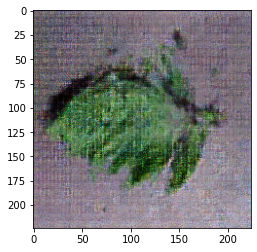

In [19]:
plot_image(img0)

In [20]:
pil_img = Image.fromarray(im)
print(pil_img.mode)
# RGB

pil_img.save('data/temp/lena_save_pillow.jpg')

NameError: ignored

In [ ]:
from PIL import Image
im = Image.fromarray(img0)
im.save("your_file.jpeg")

In [ ]:
print(type(img0), img0.shape)
plt.imshow(img0)
vutils.save_image(img0.numpy(), 'test.png')

In [ ]:
from torchvision.utils import save_image
import torch
import torchvision

tensor= torch.rand(2, 3, 400, 711) 

img1 = img0
save_image(img1, '/content/drive/My Drive/Colab Notebooks/w210/WGAN_gp-tamuraphys/data/img1.png')
plt.imshow(img0)

In [ ]:
print((real_batch[0][1]), len(real_batch[0]))
plt.imshow(np.transpose(0.5*(real_batch[0][63]+1)))

In [40]:
plt.savefig('test.png', img0.numpy())

TypeError: ignored

<Figure size 432x288 with 0 Axes>

In [20]:
#images.shape #torch.Size([64,3,28,28])
#img1 = images[0] #torch.Size([3,28,28]
# img1 = img1.numpy() # TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>
save_image(img0, 'img1.png')

TypeError: ignored

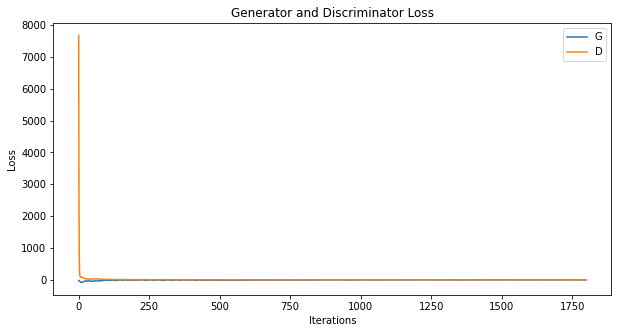

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

In [ ]:
for i in range(10):
    plt.imshow(images[i])
    plt.show()